In [2]:
import pandas as pd

# load the training dataset
diabetes = pd.read_csv('diabetes.csv')
def func(row):
    if row['Age'] <30 :
        return '20s'
    elif row['Age'] <40:
        return '30s'
    elif row['Age'] < 50:
        return '40s'
    elif row['Age'] < 60:
        return '50s'
    elif row['Age'] < 70:
        return '60s'
    else:
        return '70+'
diabetes['AgeGroup'] = diabetes.apply(func,axis=1)
diabetes.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,AgeGroup
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0,20s
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0,20s
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0,20s
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1,40s
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0,20s


In [2]:
# Separate features and labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','AgeGroup']
label = 'Diabetic'
X, y = diabetes[features].values, diabetes[label].values

for n in range(0,4):
    print("Patient", str(n+1), "\n  Features:",list(X[n]), "\n  Label:", y[n])

Patient 1 
  Features: [0, 171, 80, 34, 23, 43.50972593, 1.213191354, '20s'] 
  Label: 0
Patient 2 
  Features: [8, 92, 93, 47, 36, 21.24057571, 0.158364981, '20s'] 
  Label: 0
Patient 3 
  Features: [7, 115, 47, 52, 35, 41.51152348, 0.079018568, '20s'] 
  Label: 0
Patient 4 
  Features: [9, 103, 78, 25, 304, 29.58219193, 1.282869847, '40s'] 
  Label: 1


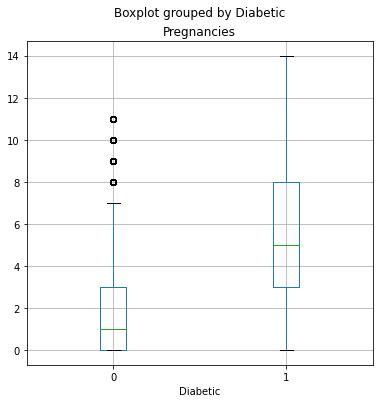

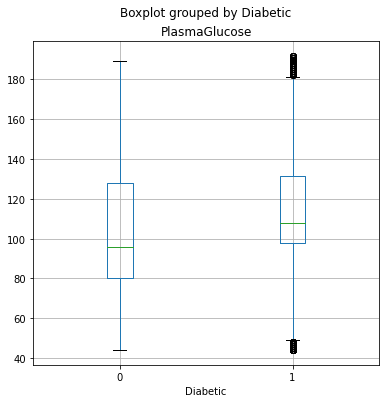

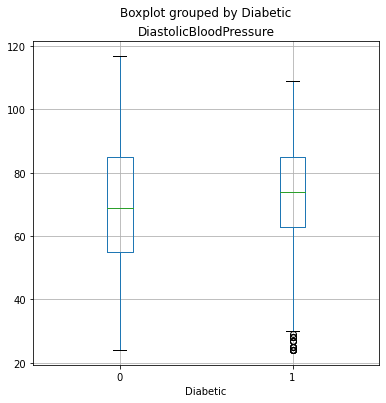

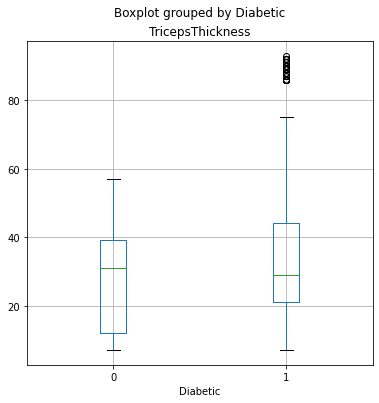

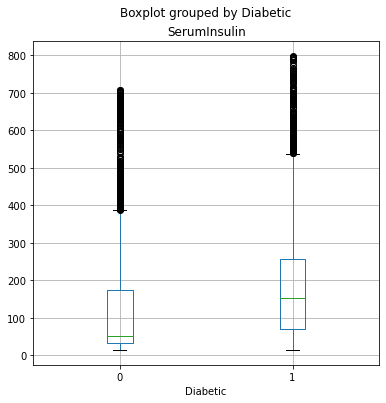

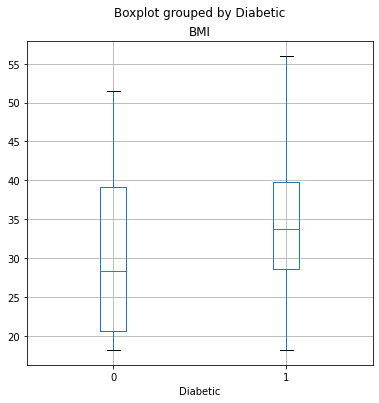

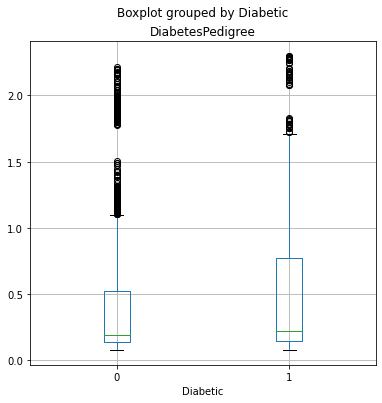

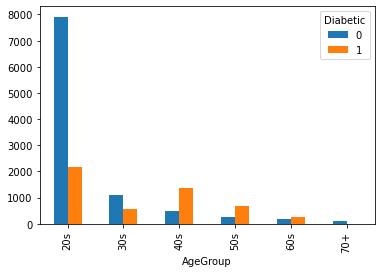

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','AgeGroup']
for col in features:
    if col == 'AgeGroup':
        diabetes.groupby(['AgeGroup','Diabetic']).size().unstack().plot.bar()
    else: 
        diabetes.boxplot(column=col, by='Diabetic', figsize=(6,6))
        plt.title(col)
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))



Training cases: 10500
Test cases: 4500


In [5]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age Group column)
categorical_features = [7]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [6]:
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.fit_transform(X_test)

slice_pipe = preprocessor.named_transformers_['cat']
cat_features = slice_pipe.named_steps['onehot'].get_feature_names(['AgeGroup'])
colname=[*features[0:7],*cat_features]

X_train_df = pd.DataFrame(X_train_trans,columns =colname)
X_test_df = pd.DataFrame(X_test_trans, columns = colname)


In [18]:
   # Model Evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, plot_roc_curve
import shap
   
def evaluate_model(model, X_test, y_test):
    '''Evaluates a sci-kit learn classification model and displays a classification report, 
    a confusion matrix, and a ROC-AUC plot.'''
    
    # Predictions
    y_hat_test = model.predict(X_test)
    
    # Classification Report
    print('                 Classification Report')
    print('-------------------------------------------------------')
    print(classification_report(y_test, y_hat_test))

    y_scores = model.predict_proba(X_test_df)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('\nAUC: ' + str(auc))
    
    # Confusion Matrix Plot
    fig, axes = plt.subplots(figsize = (12, 6), ncols = 2)
    plot_confusion_matrix(model, X_test, y_test, normalize = 'true',
                          cmap = 'Blues', ax = axes[0])
    
    cm = confusion_matrix(y_test, y_hat_test)
    print ('Confusion Matrix:\n',cm, '\n')
    # ROC-AUC Curve
    roc_auc_plot = plot_roc_curve(model, X_test, y_test, ax = axes[1])
    axes[1].legend()
    axes[1].plot([0,1], [0,1], ls = ':')
    axes[1].grid()
    axes[1].set_title('ROC-AUC Plot')
    fig.tight_layout()
    plt.show()
# Evaluate model
# evaluate_model(best_xgb_model, X_test_df, y_test)

[08:23:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2986
           1       0.90      0.89      0.90      1514

    accuracy                           0.93      4500
   macro avg       0.92      0.92      0.92      4500
weighted avg       0.93      0.93      0.93      4500


AUC: 0.9811154166382794
Confusion Matrix:
 [[2836  150]
 [ 161 1353]] 



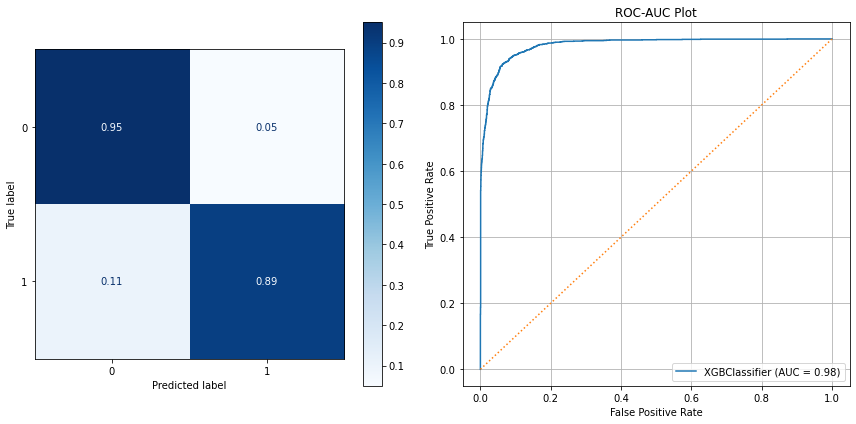

In [19]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

X_train_transfer = preprocessor.fit_transform(X_train_df)
X_test_transfer = preprocessor.fit_transform(X_test_df)

model=XGBClassifier(n_estimators =100, learning_rate =0.05, use_label_encoder=False)

model.fit(X_train_df, y_train)
# Create preprocessing and training pipeline
#pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           #('logregressor', RandomForestClassifier(n_estimators=100))])
#                        ('logregressor', XGBClassifier(n_estimators=100,learning_rate=0.05))])

# fit the pipeline to train a random forest model on the training set
#model = pipeline.fit(X_train, (y_train))
# Evaluate model
evaluate_model(model, X_test_df, y_test)

In [20]:
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier()
params = {'booster': ['gbtree', 'gblinear', 'dart'],
          'eta': [0.03, 0.05, 0.1],
          'gamma': [0, 1, 5],
          'max_depth': [3, 5, 10],
          'min_child_weight': [1, 3], 
          'sampling_method': ['uniform', 'gradient_based'], 
          'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist']}


# Fit the grid
grid = GridSearchCV(estimator = estimator, 
                    param_grid = params, 
                    cv = 3, 
                    n_jobs = -1)
grid.fit(X_train_df, y_train)
# Fit a new model with the best parameters
best_xgb_params = grid.best_params_
best_xgb_model = XGBClassifier(**best_xgb_params)
best_xgb_model.fit(X_train_df, y_train)



[09:09:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:09:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, sampling_method='uniform',
              scale_pos_weight=1, subsample=1, tree_method='auto',
              validate_parameters=1, verbosity=None)

                 Classification Report
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2986
           1       0.92      0.90      0.91      1514

    accuracy                           0.94      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.94      0.94      0.94      4500


AUC: 0.9843840830082436
Confusion Matrix:
 [[2862  124]
 [ 150 1364]] 



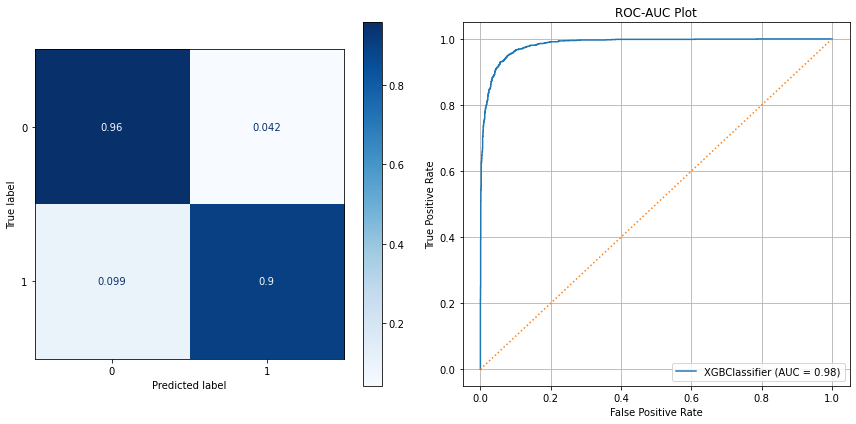

In [21]:
evaluate_model(best_xgb_model, X_test_df, y_test)

In [22]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(best_xgb_model, random_state=0).fit(X_test_df, y_test)
eli5.show_weights(perm, feature_names = colname)

Weight,Feature
0.1156 ± 0.0073,Pregnancies
0.0418 ± 0.0026,BMI
0.0265 ± 0.0046,SerumInsulin
0.0214 ± 0.0036,PlasmaGlucose
0.0173 ± 0.0047,TricepsThickness
0.0080 ± 0.0015,AgeGroup_20s
0.0076 ± 0.0011,DiastolicBloodPressure
0.0036 ± 0.0013,DiabetesPedigree
0.0017 ± 0.0007,AgeGroup_30s
0.0010 ± 0.0022,AgeGroup_40s


In [23]:
# Pull feature importances
features_dict = {'Features': X_train_df.columns, 
                 'Importance': best_xgb_model.feature_importances_}
# Convert to a dataframe
feature_importance = pd.DataFrame(features_dict, columns = ['Features','Importance'])
# Removing all features with a 0 importance
for i in feature_importance['Importance']:
    if i == 0:
        feature_importance['Importance'].replace(i, np.nan, inplace = True)
        
feature_importance.dropna(inplace = True)
# Sorting the importances
feature_importance.sort_values(by = ['Importance'], ascending = False, inplace = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Pregnancies'),
  Text(1, 0, 'BMI'),
  Text(2, 0, 'AgeGroup_20s'),
  Text(3, 0, 'AgeGroup_70+'),
  Text(4, 0, 'AgeGroup_30s'),
  Text(5, 0, 'SerumInsulin'),
  Text(6, 0, 'PlasmaGlucose'),
  Text(7, 0, 'AgeGroup_40s'),
  Text(8, 0, 'TricepsThickness'),
  Text(9, 0, 'DiastolicBloodPressure')])

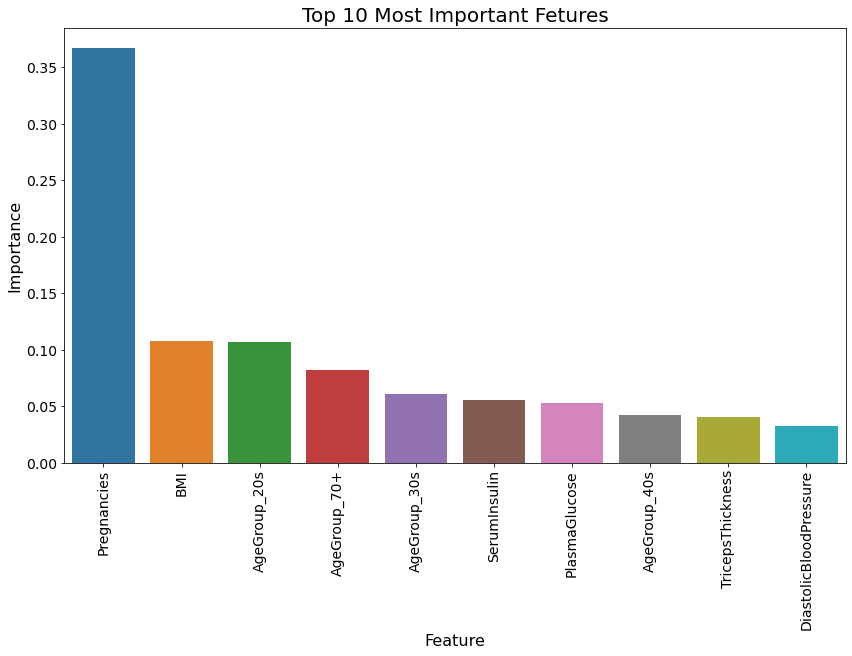

In [24]:
# Let's plot the feature importances
ax = plt.figure(figsize = (14, 8))
ax = sns.barplot(data = feature_importance.head(10), 
                 x = 'Features', y = 'Importance')
ax.set_title('Top 10 Most Important Fetures', fontsize = 20)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Importance', fontsize = 16)
ax.tick_params(labelsize = 14)
plt.xticks(rotation = 90)

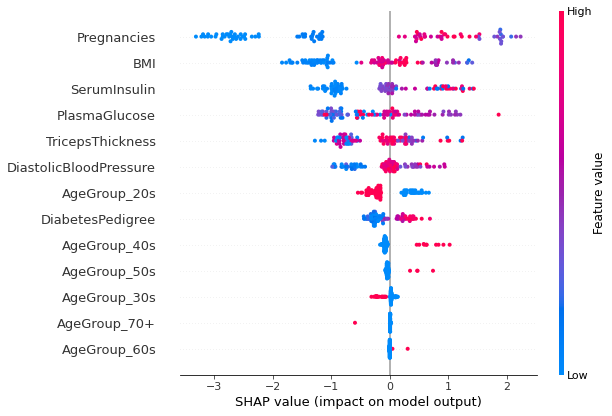

In [25]:
# Setting up SHAP
X_shap = shap.sample(X_train_df, 100)
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_shap)
# Another shap plot that shows how each feature affects churn
shap.summary_plot(shap_values, X_shap)
